In [50]:
#from fuzzy_art import *
from fuzzyART_gai import *
from handytools import *
#import sklearn.datasets as ds
import sklearn.decomposition as dcp
import matplotlib.pyplot as plt

In [51]:
repetition = 5
data = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,1,1,0],[0,0,0,0,1,1]] * repetition)
label_true = np.array([0,1,2,3,4] * repetition)
# pca
pca = dcp.PCA(n_components=2)
pca_xy = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.46875    0.33070549]
[3.87298335 3.2530871 ]


In [52]:
# use FuzzyART
# init
rho = 0.7
net = FuzzyARTgai(alpha=0.5, rho=rho) 

# train
net.train(data, epochs=100) # each epoch, all data is shuffled

true prediction: [0 1 2 3 0 1 2 0 1 0]
 ART prediction: [0 0 1 2 0 0 1 0 0 0]


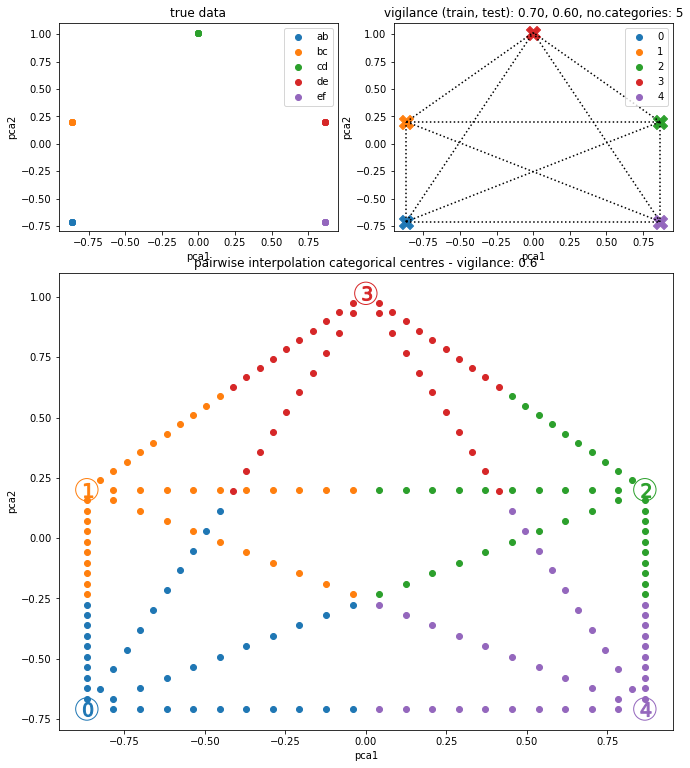

In [70]:
fig, axs = plt.subplot_mosaic("""
                                AB
                                CC
                                CC
                                """,
                                figsize=(11, 13))
#fig.tight_layout()

# plot true
for cat_true, lb_true in enumerate(['ab','bc','cd','de','ef']):
    axs['A'].scatter(*np.where(label_true == cat_true, pca_xy.T, None), label = lb_true)
axs['A'].set_title('true data')

test_rho = 0.6
isdiff_traintest = net._set_properties(rho = test_rho) # no change of model properties from training
test_rho = net.rho
label_pred = net.test(data).astype(int)

cat_number = net.w.shape[0]
replay_cat = net.w[:, :data.shape[1]]
cat_centre = pca.transform(replay_cat)

# plot cats
for cat_pred, cat_x, cat_y in zip(range(cat_number), *cat_centre.T):
    c = next(axs['B']._get_lines.prop_cycler)['color']
    axs['B'].scatter(*np.where(label_pred == cat_pred, pca_xy.T, None), color = c, label = cat_pred) # all training samples
    axs['B'].scatter(cat_x, cat_y, marker = 'X', s = 200, color = c) # categorical centre
    axs['C'].scatter(cat_x, cat_y, marker = 'o', s = 500, facecolor = 'none', edgecolor = c)
    axs['C'].scatter(cat_x, cat_y, marker = '${}$'.format(cat_pred), s = 200, color = c)
axs['B'].set_title('vigilance (train, test): {:.2f}, {:.2f}, no.categories: {}'.format(rho, test_rho, cat_number))

# plot inters
ls_interidx, ls_intercat = [], []
for i in range(cat_number):
    for j in range(i + 1, cat_number):
        interidx = np.array([i, j])
        ls_interidx.append(interidx) 
        axs['B'].plot(*cat_centre[interidx].T, c = 'k', ls = 'dotted')

        intercat = interp2coordinates(*replay_cat[interidx], 20)
        intercat_label = net.test(intercat).astype(int)
        ls_intercat.append(intercat_label)
        axs['B'].set_prop_cycle(None)
        for cat_pred in range(cat_number):
            c = next(axs['B']._get_lines.prop_cycler)['color']
            axs['C'].scatter(*np.where(intercat_label == cat_pred, pca.transform(intercat).T, None), color = c)
        axs['C'].scatter(*np.where(intercat_label == -1, pca.transform(intercat).T, None), color = 'k', marker = '^')

ls_intercat = np.array(ls_intercat)
axs['C'].set_title('pairwise interpolation categorical centres - vigilance: {}'.format(test_rho))

# plot ti
data_ti = np.array([[1,0,1,0,0,0], [0,1,0,1,0,0], [0,0,1,0,1,0], [0,0,0,1,0,1],
                    [1,0,0,1,0,0], [0,1,0,0,1,0], [0,0,1,0,0,1],
                    [1,0,0,0,1,0], [0,1,0,0,0,1],
                    [1,0,0,0,0,1]])
ideal_ti = np.array([0,1,2,3,
                     0,1,2,
                     0,1,
                     0])
pca_ti = pca.transform(data_ti)
label_ti = net.test(data_ti).astype(int)
print("true prediction: {}\n ART prediction: {}".format(ideal_ti, label_ti))

for idx in 'ABC':
    axs[idx].set_xlabel('pca1')
    axs[idx].set_ylabel('pca2')
    
for idx in 'AB':    
    axs[idx].legend()

simname = 'intercat'
dirname = '_simcache'
savefigure_datetime(fig, simname, dirname)